# Tesis - Turbomáquina

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import DBSCAN

La suposición implícita de modelar los siguientes datos es que el activo de interés tiene un patrón de degradación progresiva, que se refleja en las mediciones de los sensores.

# Lectura de la data

In [2]:
# Como los archivos de entrada no tienen nombres de columnas, se les agregaran ahora

atributos = ['id', 'cycle', 'setting1', 'setting2', 'setting3','sen1','sen2', 'sen3', 'sen4', 'sen5', 
             'sen6', 'sen7', 'sen8', 'sen9', 'sen10','sen11', 'sen12', 'sen13', 'sen14', 'sen15', 
             'sen16', 'sen17', 'sen18', 'sen19', 'sen20', 'sen21']

def get_sensor_names(atributos):
    """ Obtiene los atributos que comiencen con "sen".
    
    :param atributos: columnas de las series de tiempo.
    
    :return lista de string comenzando con "sen".
    """
    
    return [a for a in atributos if a.startswith('sen')]

sensor_columns = get_sensor_names(atributos)

train_data = pd.read_csv('train_FD001.txt', sep=' ', header=None)
test_data = pd.read_csv('test_FD001.txt', sep=' ', header=None)
RUL_data = pd.read_csv('RUL_FD001.txt', sep=' ', header=None)

train_data = train_data.dropna(how='all', axis=1)
test_data = test_data.dropna(how='all', axis=1)
RUL_data = RUL_data.dropna(how='all', axis=1)

train_data.columns = atributos
test_data.columns = atributos
RUL_data.columns = ['RUL']

In [3]:
train_data.head()

,id,cycle,setting1,setting2,setting3,sen1,sen2,sen3,sen4,sen5,...,sen12,sen13,sen14,sen15,sen16,sen17,sen18,sen19,sen20,sen21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
test_data.head()

,id,cycle,setting1,setting2,setting3,sen1,sen2,sen3,sen4,sen5,...,sen12,sen13,sen14,sen15,sen16,sen17,sen18,sen19,sen20,sen21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [5]:
RUL_data.head()

,RUL
0,112
1,98
2,69
3,82
4,91


In [6]:
print('El dataset de entrenamiento tiene {} filas y {} atributos.'.format(*train_data.shape))
print('El dataset de prueba tiene {} filas y {} atributos.'.format(*test_data.shape))
print('El dataset de vida útil remanente tiene {} filas y {} atributo.'.format(*RUL_data.shape))

El dataset de entrenamiento tiene 20631 filas y 26 atributos.
El dataset de prueba tiene 13096 filas y 26 atributos.
El dataset de vida útil remanente tiene 100 filas y 1 atributo.


* Datos de entrenamiento: son los datos de ejecución del motor del avión desde el estado inicial hasta al fallo.
* Datos de prueba: Son los datos de operación del motor de la aeronave sin eventos de falla registrados.
* Datos RUL: contiene la información de los ciclos verdaderos restantes para cada motor en los datos de prueba.

Los datos de entrenamiento __("train_FD001.txt")__ consisten en múltiples series de tiempo multivariantes con "ciclos" como unidad de tiempo, junto con 21 lecturas de sensores para cada ciclo. Se puede suponer que cada serie de tiempo se genera a partir de un motor diferente del mismo tipo. Además, también se supone que cada motor comienza con diferentes grados de desgaste inicial y variación de fabricación, y esta información es desconocida para el usuario.

__En estos datos de entrenamiento__, se supone que el motor está funcionando normalmente al comienzo de cada serie de tiempo, luego, comienza a degradarse en algún momento durante la serie de los ciclos operativos. La degradación progresa y crece en magnitud. Cuando se alcanza un umbral predefinido, entonces el motor se considera inseguro para una operaciones posteriores. En otras palabras, __el último ciclo en cada serie de tiempo puede considerarse como el punto de falla del motor correspondiente.__

Tomando como ejemplo los datos de entrenamiento, el motor con id = 1 falla en el ciclo 192, y el motor con id = 2 falla en el ciclo 287.

Los datos de prueba __("test_FD001.txt")__ tienen el mismo esquema que los datos de entrenamiento. La única diferencia es que __los datos no indican cuándo ocurre la falla (en otras palabras, el último período de tiempo NO representa el punto de falla).__ Tomando como ejemplo los datos de prueba, el motor con id = 1 funciona desde el ciclo 1 hasta el ciclo 31. No se muestran cuántos ciclos más puede durar este motor antes de que falle.

Los datos de vida útil remanente __("RUL_FD001.txt")__ __proporciona el número de ciclos de trabajo restantes para los motores en los datos de prueba.__ Tomando como ejemplo los datos RUL, el motor con id = 1 en los datos de prueba puede ejecutar otros 112 ciclos antes de que falle.

* Basándonos en la descripción de datos de entrada que hemos examinado en los parrafos anteriores, __una pregunta intuitiva de mantenimiento predictivo es: "Teniendo en cuenta el funcionamiento de este motor de avión y el historial de eventos de fallas, ¿Podemos predecir cuándo fallará un motor en servicio?"__

In [7]:
# Verificando los tipos de datos en cada columna para cada dataset

print(train_data.dtypes)
print('\n')
print(test_data.dtypes)
print('\n')
print(RUL_data.dtypes)

id            int64
cycle         int64
setting1    float64
setting2    float64
setting3    float64
sen1        float64
sen2        float64
sen3        float64
sen4        float64
sen5        float64
sen6        float64
sen7        float64
sen8        float64
sen9        float64
sen10       float64
sen11       float64
sen12       float64
sen13       float64
sen14       float64
sen15       float64
sen16       float64
sen17         int64
sen18         int64
sen19       float64
sen20       float64
sen21       float64
dtype: object


id            int64
cycle         int64
setting1    float64
setting2    float64
setting3    float64
sen1        float64
sen2        float64
sen3        float64
sen4        float64
sen5        float64
sen6        float64
sen7        float64
sen8        float64
sen9        float64
sen10       float64
sen11       float64
sen12       float64
sen13       float64
sen14       float64
sen15       float64
sen16       float64
sen17         int64
sen18         int64
sen1

Todas las columnas son valores númericos.

In [8]:
# Verificando si existen valores faltantes (NaN) para cada dataset

print(train_data.isnull().sum())
print('\n')
print(test_data.isnull().sum())
print('\n')
print(RUL_data.isnull().sum())

id          0
cycle       0
setting1    0
setting2    0
setting3    0
sen1        0
sen2        0
sen3        0
sen4        0
sen5        0
sen6        0
sen7        0
sen8        0
sen9        0
sen10       0
sen11       0
sen12       0
sen13       0
sen14       0
sen15       0
sen16       0
sen17       0
sen18       0
sen19       0
sen20       0
sen21       0
dtype: int64


id          0
cycle       0
setting1    0
setting2    0
setting3    0
sen1        0
sen2        0
sen3        0
sen4        0
sen5        0
sen6        0
sen7        0
sen8        0
sen9        0
sen10       0
sen11       0
sen12       0
sen13       0
sen14       0
sen15       0
sen16       0
sen17       0
sen18       0
sen19       0
sen20       0
sen21       0
dtype: int64


RUL    0
dtype: int64


¡No hay valores faltantes en ningún dataset!

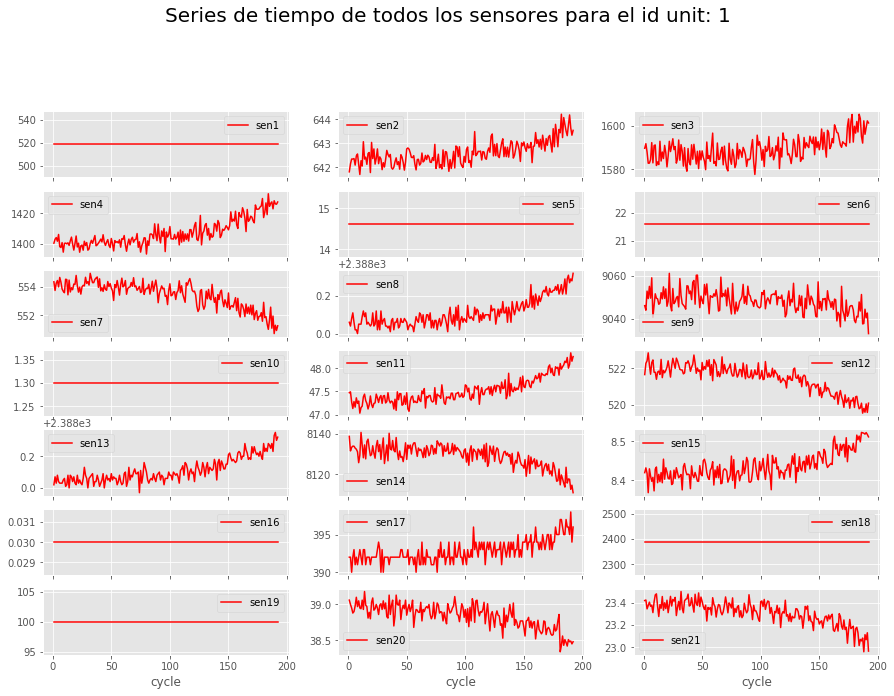

In [9]:
# Graficando los datos de prueba y entrenamiento

def time_series(data,ii):
    
    """ Gráfica las series de tiempo para el id_unit especificado.
    
        Args:
        data (DataFrame): DataFrame con los datos a graficar.
        ii (int): valor del id. 

    Returns:
        plots"""
        
    engine = data[(data.id == ii)] #Tomo sólo las filas que coincidan con el id seleccionado.

    fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True) #Creo 21 gráficas en el orden 7x3.
    fig.suptitle("Series de tiempo de todos los sensores para el id unit: "+str(ii), size=20, y=1.025)

    for i, ax in enumerate(axes.ravel()):
        engine.plot(x='cycle', y='sen'+str(i+1), color = 'red', ax=ax) #Gráfico todos los sensores.

time_series(train_data, 1)

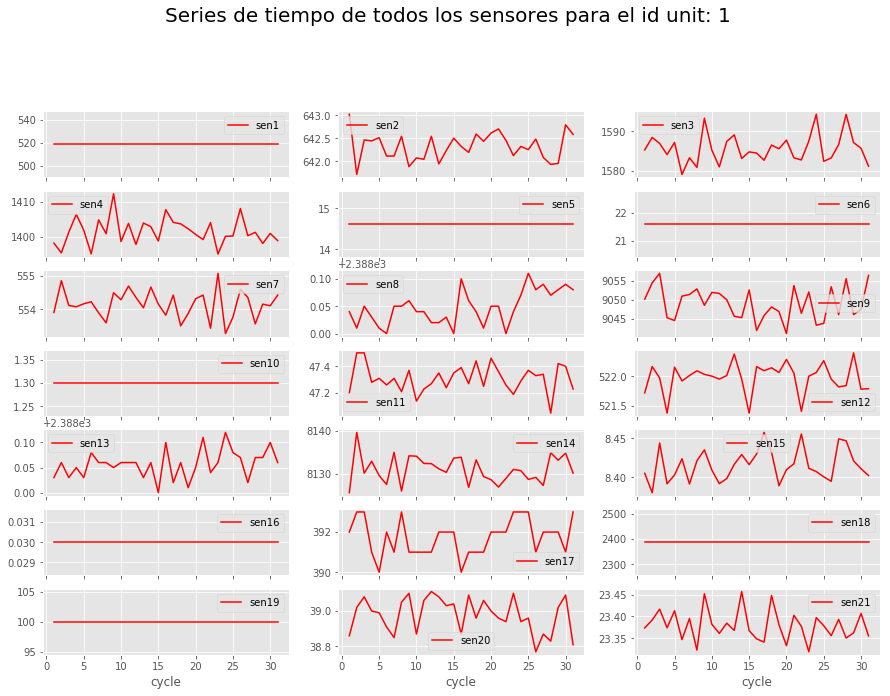

In [10]:
time_series(test_data, 1)

In [11]:
# Removiendo las columnas con desviación estándar igual a cero.

df = train_data.loc[:, train_data.std() > 0.01]

# Análisis exploratorio de los datos:

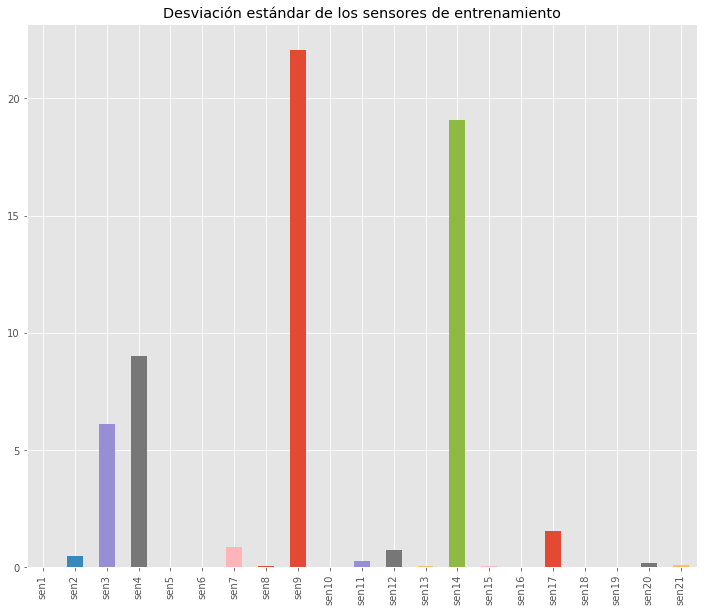

In [12]:
# Verificando que tan dispersos están los datos de los sensores.

data2 = train_data[sensor_columns] #Tomo solo las columnas de los sensnores.
data2.std().plot(kind='bar', figsize=(12, 10), title = 'Desviación estándar de los sensores de entrenamiento')

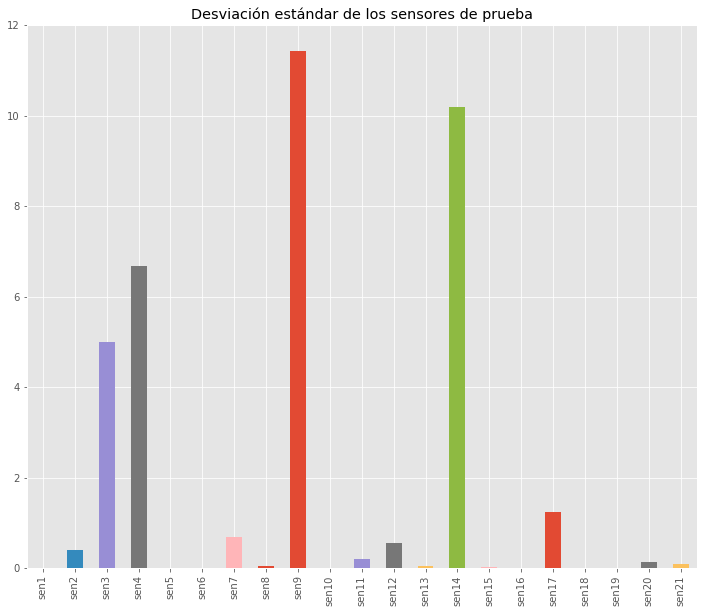

In [13]:
data3 = test_data[sensor_columns]
data3.std().plot(kind='bar', figsize=(12, 10), title = 'Desviación estándar de los sensores de prueba')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E6F3DEF2B0>,
      dtype=object)

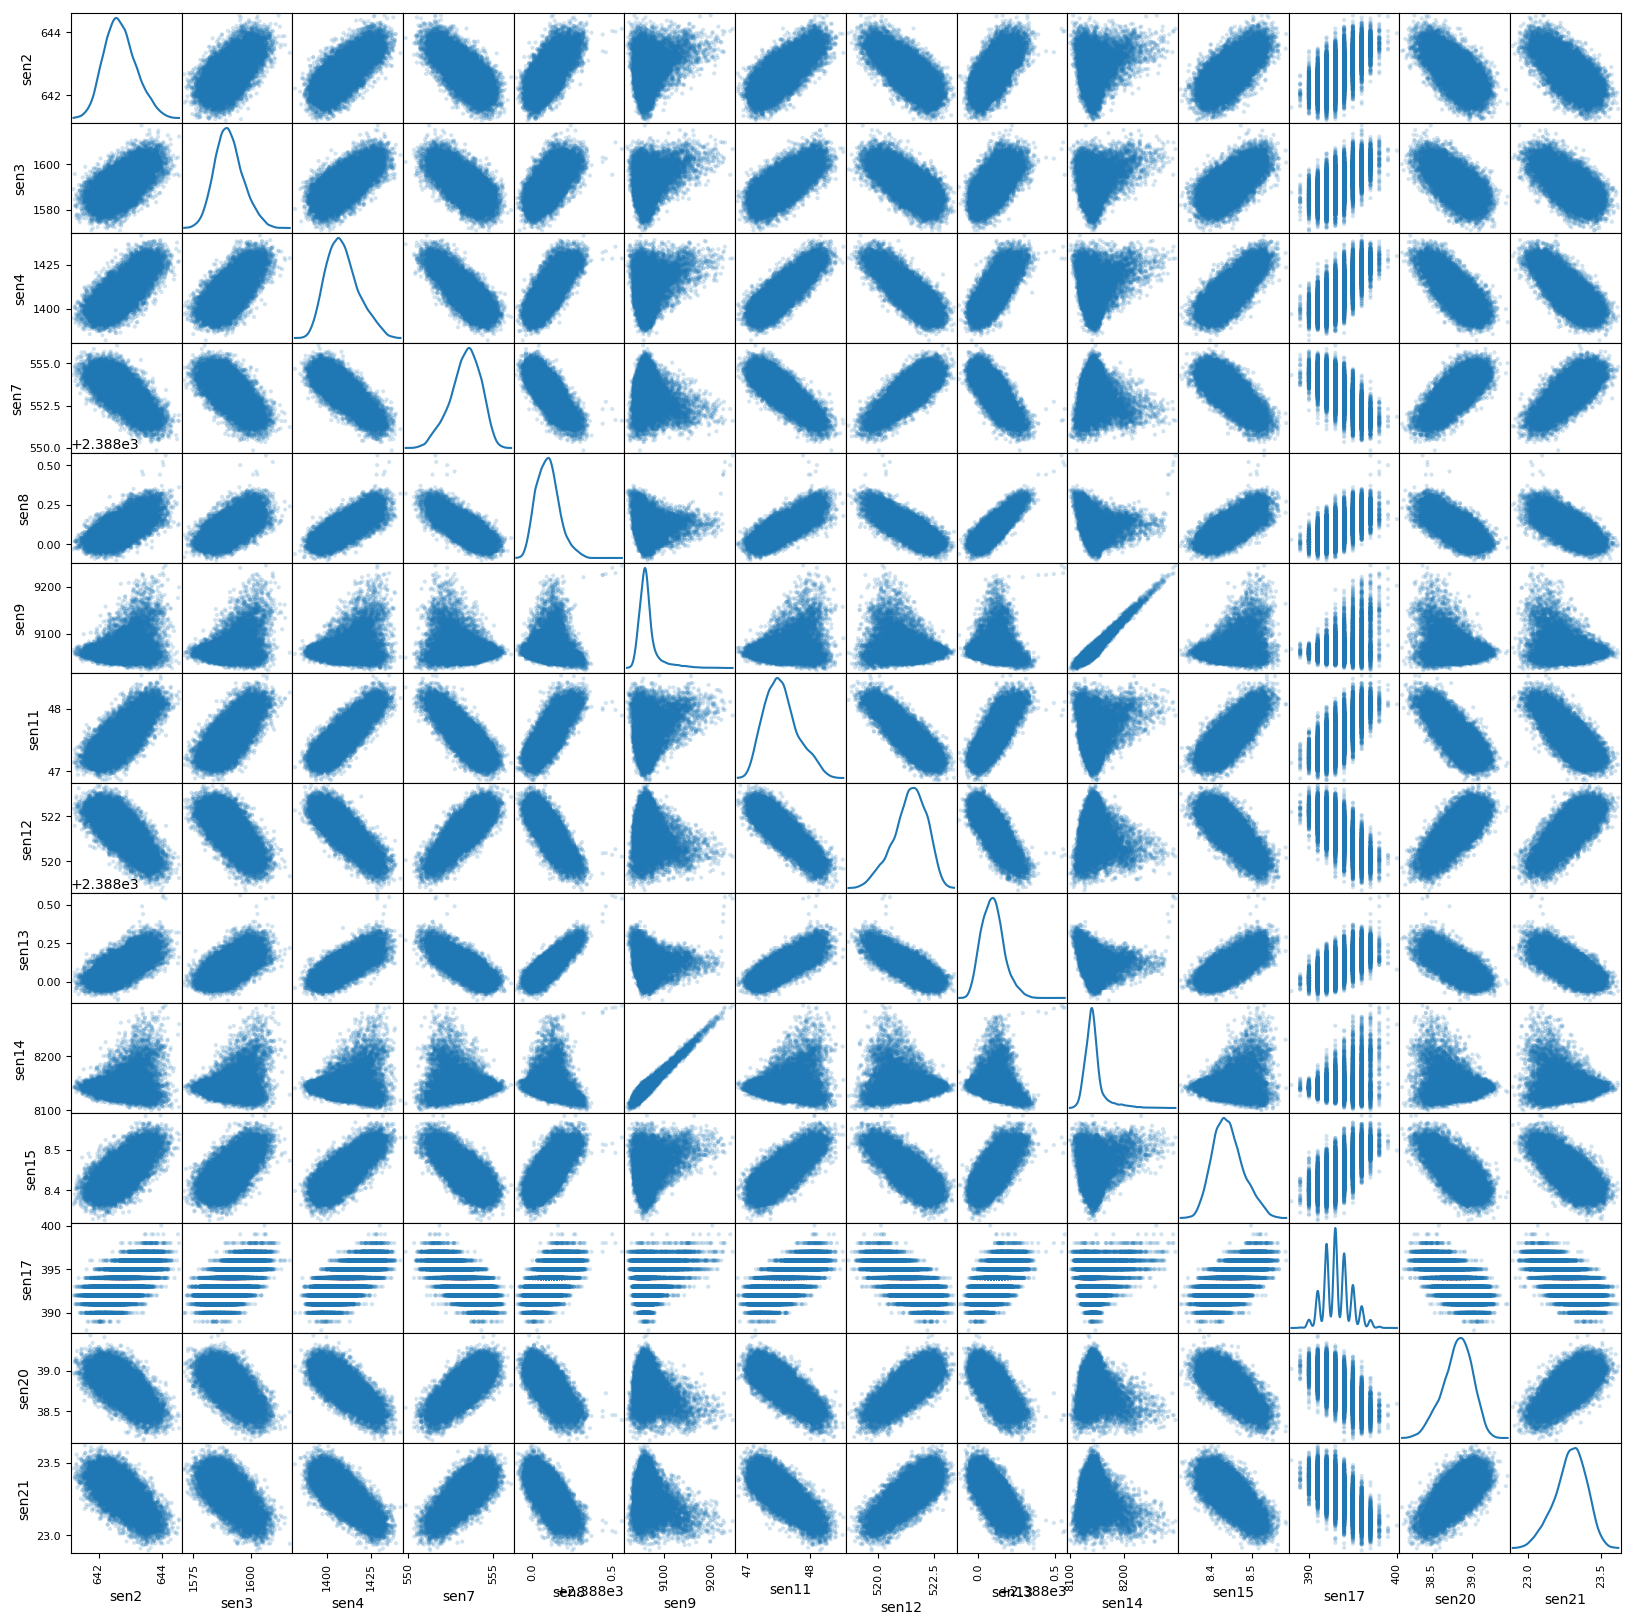

In [14]:
sns.reset_orig()
df_new = train_data[sensor_columns].loc[:, train_data[sensor_columns].std() > 0.01]
scatter_matrix(df_new, alpha=0.2, figsize=(20, 20), diagonal='kde')

Con estas graficas se evidencia que hay sensores, como el s9, con datos altamente dispersos con respecto a su promedio.

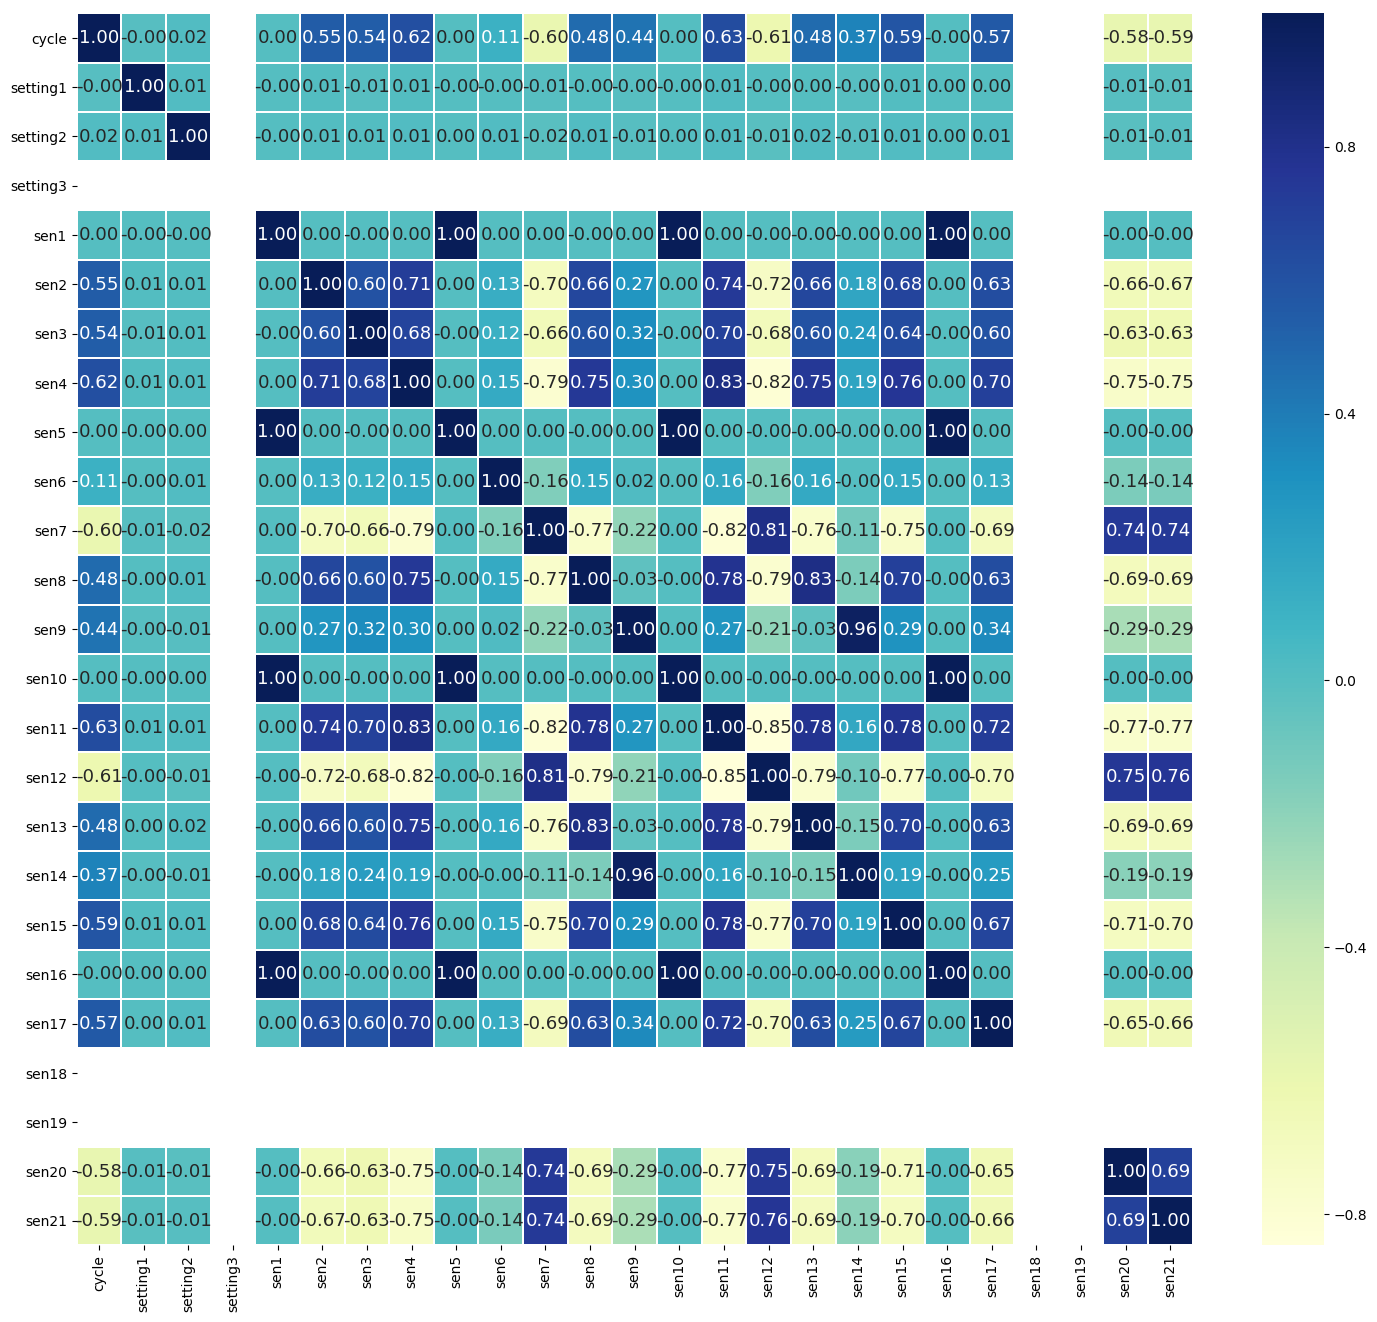

In [15]:
# Matriz de correlación ENTRENAMIENTO

plt.figure(figsize = (18, 16))
sns.heatmap(train_data.drop(['id'], axis = 1).corr(), \
            annot= True, fmt='0.2f', annot_kws={'size': 13}, linewidths=.7, cmap="YlGnBu")
plt.show()

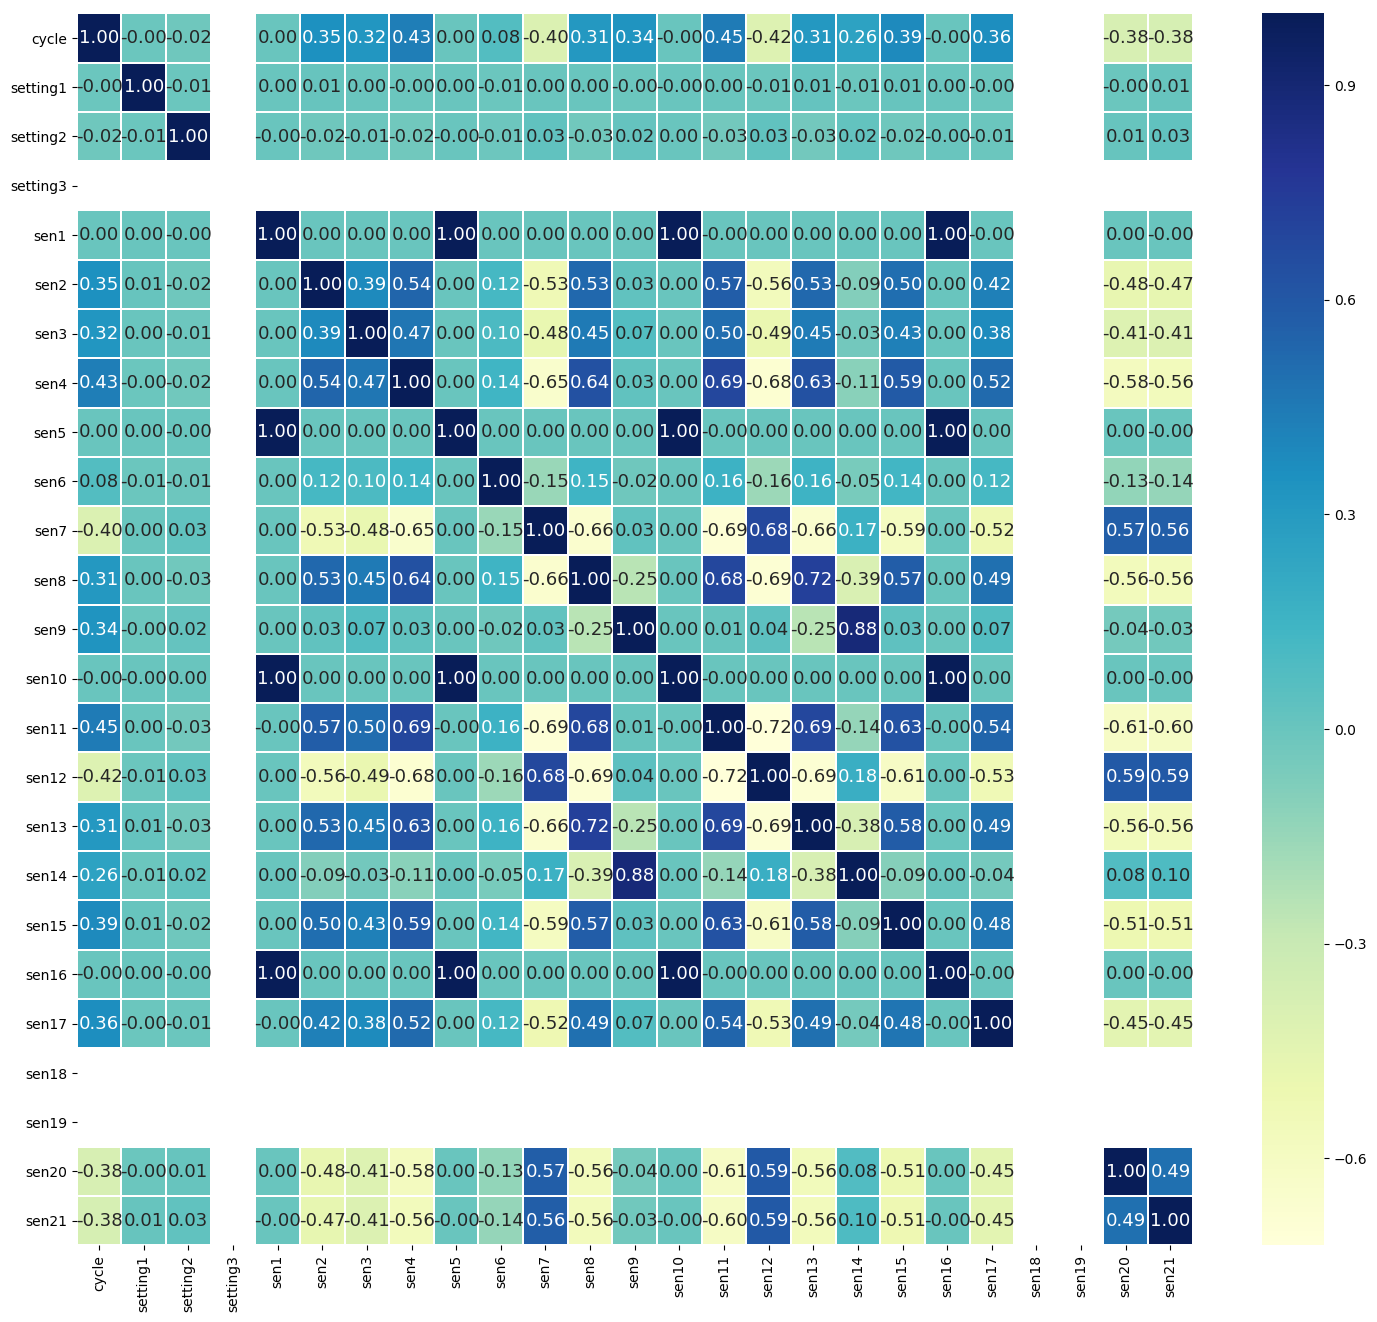

In [16]:
# Matriz de correlación PRUEBA

plt.figure(figsize = (18, 16))
sns.heatmap(test_data.drop(['id'], axis = 1).corr(), \
            annot= True, fmt='0.2f', annot_kws={'size': 13}, linewidths=.7, cmap="YlGnBu")
plt.show()

In [17]:
# Datos estadísticos de la data de entrenamiento.

train_data.describe(include='all')

,id,cycle,setting1,setting2,setting3,sen1,sen2,sen3,sen4,sen5,...,sen12,sen13,sen14,sen15,sen16,sen17,sen18,sen19,sen20,sen21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [18]:
test_data.describe(include='all')

,id,cycle,setting1,setting2,setting3,sen1,sen2,sen3,sen4,sen5,...,sen12,sen13,sen14,sen15,sen16,sen17,sen18,sen19,sen20,sen21
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,1.309600e+04,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,5.186700e+02,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,6.014263e-11,0.400899,5.003274,6.688309,2.671743e-12,...,0.559627,0.056934,10.188605,0.029009,8.823140e-15,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,5.186700e+02,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,0.000000,0.000000,100.0,5.186700e+02,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,5.186700e+02,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,5.186700e+02,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


Hay 100 simulaciones, cada simulación tiene entre 1 a 362 ciclos (con un promedio de 108 ciclos por simulación). Donde, el último ciclo para cada simulación representa el ciclo donde ocurrió la falla.

C:\Users\Porti\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


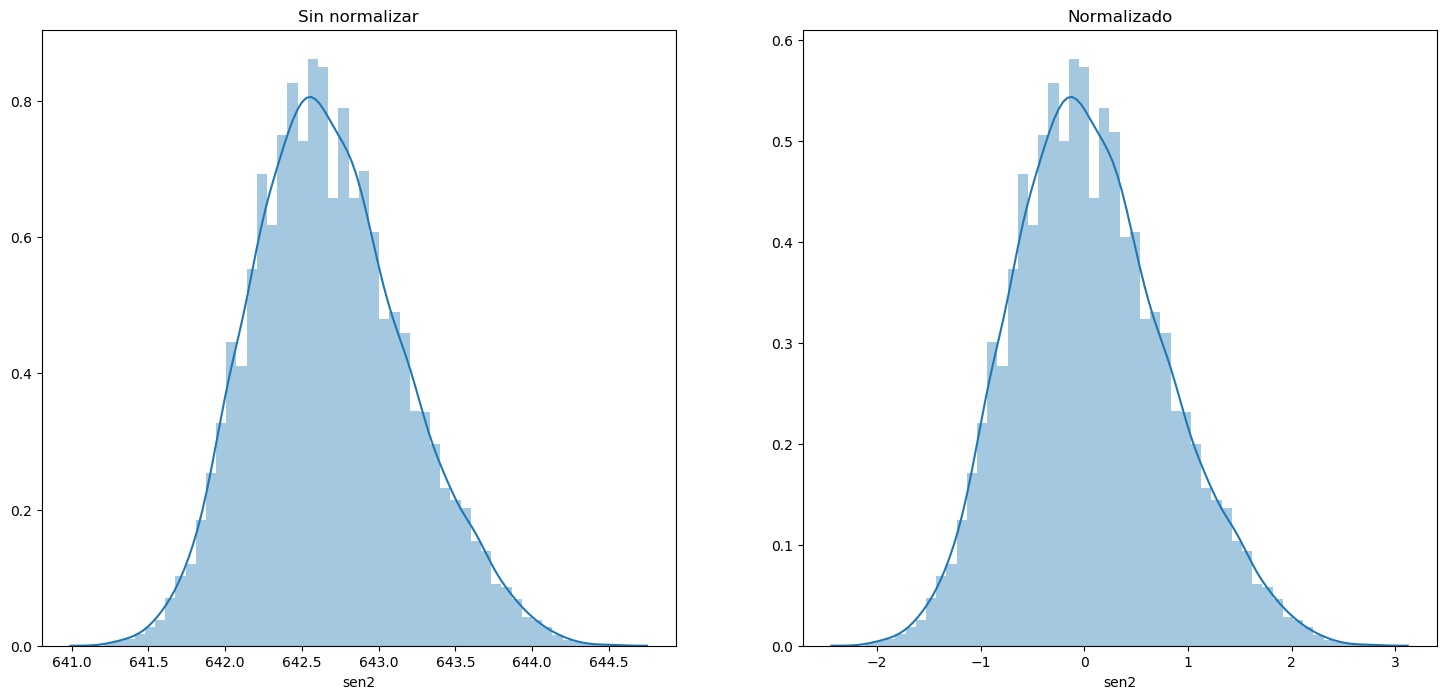

In [19]:
scaler = preprocessing.RobustScaler() #Aplico un proceso de escalamiento robusto, apropiedo para data con outliers.
robust = scaler.fit_transform(train_data) #Indico a que data se le hará el escalamiento. Salida: np.array
robust = pd.DataFrame(robust, columns= atributos) #Convierto dicho array en un DF.

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize= (18,8))

ax1.set_title('Sin normalizar')
sns.distplot(data2['sen2'], ax=ax1)

ax2.set_title('Normalizado')
sns.distplot(robust['sen2'], ax=ax2)
plt.show()

In [20]:
robust.head()

,id,cycle,setting1,setting2,setting3,sen1,sen2,sen3,sen4,sen5,...,sen12,sen13,sen14,sen15,sen16,sen17,sen18,sen19,sen20,sen21
0,-1.0,-0.990385,-0.233333,-0.8,0.0,0.0,-1.214815,-0.049261,-0.610086,0.0,...,0.181818,-0.7,-0.127448,-0.382643,0.0,-0.5,0.0,0.0,0.92,0.835172
1,-1.0,-0.980769,0.633333,-0.6,0.0,0.0,-0.725926,0.211823,-0.401804,0.0,...,0.808081,-0.2,-0.600730,-0.140039,0.0,-0.5,0.0,0.0,0.68,0.866897
2,-1.0,-0.971154,-1.433333,0.6,0.0,0.0,-0.429630,-0.259852,-0.314883,0.0,...,0.949495,-0.6,-0.485231,-0.416174,0.0,-1.5,0.0,0.0,0.48,0.319310
3,-1.0,-0.961538,0.233333,0.0,0.0,0.0,-0.429630,-0.900246,-0.505945,0.0,...,1.393939,-0.1,-0.445403,-1.394477,0.0,-0.5,0.0,0.0,0.20,0.524138
4,-1.0,-0.951923,-0.633333,-0.4,0.0,0.0,-0.400000,-0.892857,-0.149241,0.0,...,0.717172,-0.5,-0.447395,-0.187377,0.0,0.0,0.0,0.0,0.28,0.734483


In [21]:
from collections import Counter

#Aplicó el algoritmo de clustering DBSCAN de la libreria cluster de sklearn.
fit = DBSCAN(eps=210, min_samples= 100, n_jobs=-1).fit(train_data[sensor_columns])
print(fit)
print('\n')

fitted_labels = fit.labels_ #Almaceno las etiquetas de los clusters en la variable fitted_labels.
n_cluster = len(set(fitted_labels)) - (1 if -1 in fitted_labels else 0) #Calculo el # de cluster quitando los outliers.

outliers_df = pd.DataFrame(train_data[sensor_columns]) #Creo un DF con solo los sensores para almacenar los outliers.
outliers_df = outliers_df.loc[:, outliers_df.std() > 0.01] #Remuevo las columnas con desviación estándar igual a cero.

print(Counter(fitted_labels)) #Cuento cuantos elementos tiene cada cluster.
print('\n')

print('El numero de cluster estimados es: %d ' % n_cluster)

print('\n')
print('Estos son los outliers detectados por el algoritmo DBSCAN:')
print('\n')
print(outliers_df[fitted_labels == -1]) #Imprimo SOLO los outliers del DBSCAN.

DBSCAN(algorithm='auto', eps=210, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)


Counter({0: 20631})


El numero de cluster estimados es: 1 


Estos son los outliers detectados por el algoritmo DBSCAN:


Empty DataFrame
Columns: [sen2, sen3, sen4, sen7, sen8, sen9, sen11, sen12, sen13, sen14, sen15, sen17, sen20, sen21]
Index: []


In [22]:
#Se agregará una columna adicional que contenga el Time-To-Failure (TTF) en el dataset de entrenamiento

def preparacion_train(train_data, periodo):
    df_max_ciclo = train_data.groupby('id')['cycle'].max().reset_index()
    df_max_ciclo.columns = ['id', 'ultimo_ciclo']

    #Se añadirá el TTF como nueva columna a los datasets
    train_data = pd.merge(train_data, df_max_ciclo, on='id')
    train_data['ttf'] = train_data['ultimo_ciclo'] - train_data['cycle']
    train_data.drop(['ultimo_ciclo'], axis= 1, inplace= True)

    #Creando las etiquetas de clasificación
    train_data['label'] = train_data['ttf'].apply(lambda x: 1 if x <= periodo else 0)
    
    return train_data

train_data = preparacion_train(train_data, 30)
train_data.head()

,id,cycle,setting1,setting2,setting3,sen1,sen2,sen3,sen4,sen5,...,sen14,sen15,sen16,sen17,sen18,sen19,sen20,sen21,ttf,label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [23]:
# Se guardará la data de entrenamiento con formato .csv para ser usada luego.

train_data.to_csv('train.csv', index = False)

In [24]:
def preparacion_test(test_data, periodo):
    df_tst = test_data.groupby('id').cycle.max().reset_index()
    df_tst.columns = ['id', 'last_cycle']

    test_data = pd.merge(test_data, df_tst, on='id')
    test_data = test_data[test_data['cycle'] == test_data['last_cycle']]
    test_data.drop(['last_cycle'], axis=1, inplace = True)
    test_data.reset_index(drop=True, inplace=True)
    test_data = pd.concat([test_data, RUL_data], axis = 1)

    #Creando las etiquetas de clasificación
    test_data['label'] = test_data['RUL'].apply(lambda x: 1 if x <= periodo else 0)
    
    return test_data

test_data = preparacion_test(test_data, 30)
test_data.head()

,id,cycle,setting1,setting2,setting3,sen1,sen2,sen3,sen4,sen5,...,sen14,sen15,sen16,sen17,sen18,sen19,sen20,sen21,RUL,label
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552,112,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618,98,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740,69,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581,82,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117,91,0


In [25]:
# Se guardará la data de prueba con formato .csv para ser usada luego.

test_data.to_csv('test.csv', index = False)

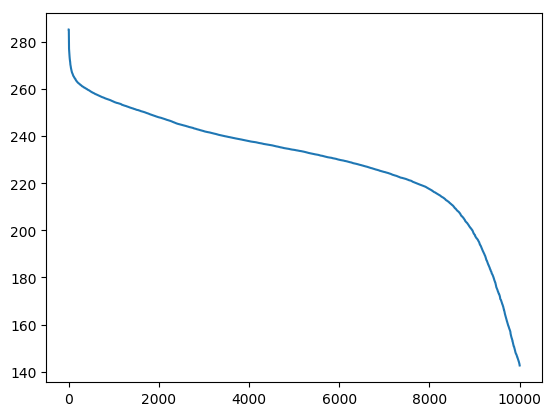

In [26]:
datas = train_data[sensor_columns]
datas1 = datas.head(10000)

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=len(datas1)).fit(datas1)
distances, indices = nbrs.kneighbors(datas1)

d = distances[:,-1]
c = sorted(d, reverse=True)
plt.plot(list(range(1,len(c)+1)), c)

# Suavizado de señal

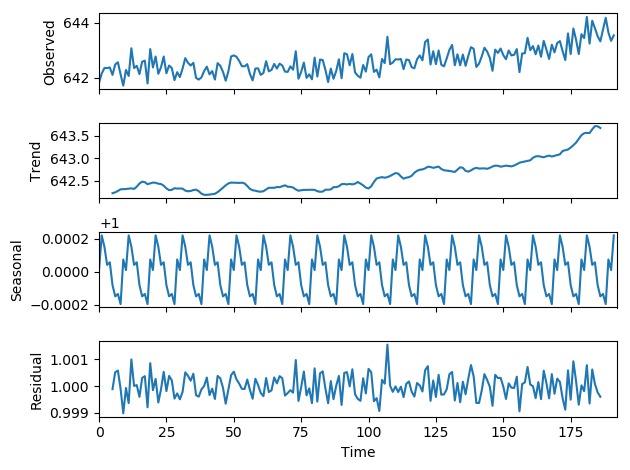

In [27]:
s2_100_cycle = train_data.loc[:,'sen2']
s2_1_cycle = train_data.loc[train_data['id'] == 1, 'sen2']
s2_1_cycle.reset_index(drop=True, inplace=True)

from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(s2_1_cycle.values, freq=10, model='multiplicative')
#print(res.trend)
resplot = res.plot()

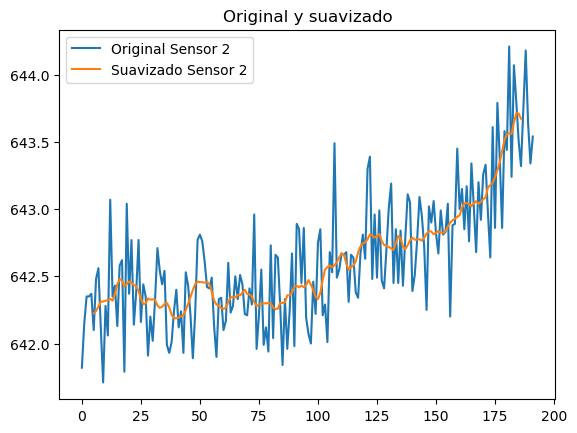

In [28]:
# Graficando data original y sin ruido
trend = res.trend
seasonal = res.seasonal
residual = res.resid

line_1, = plt.plot(s2_1_cycle, label='line 1')
line_2, = plt.plot(trend, label='line 2')
plt.title('Original y suavizado')
plt.legend([line_1, line_2], ['Original Sensor 2', 'Suavizado Sensor 2'])

# Fourier

95


C:\Users\Porti\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


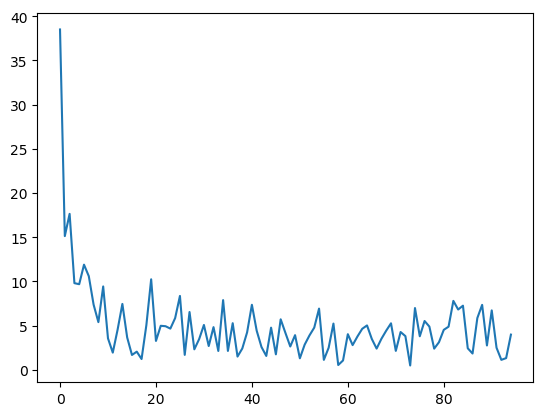

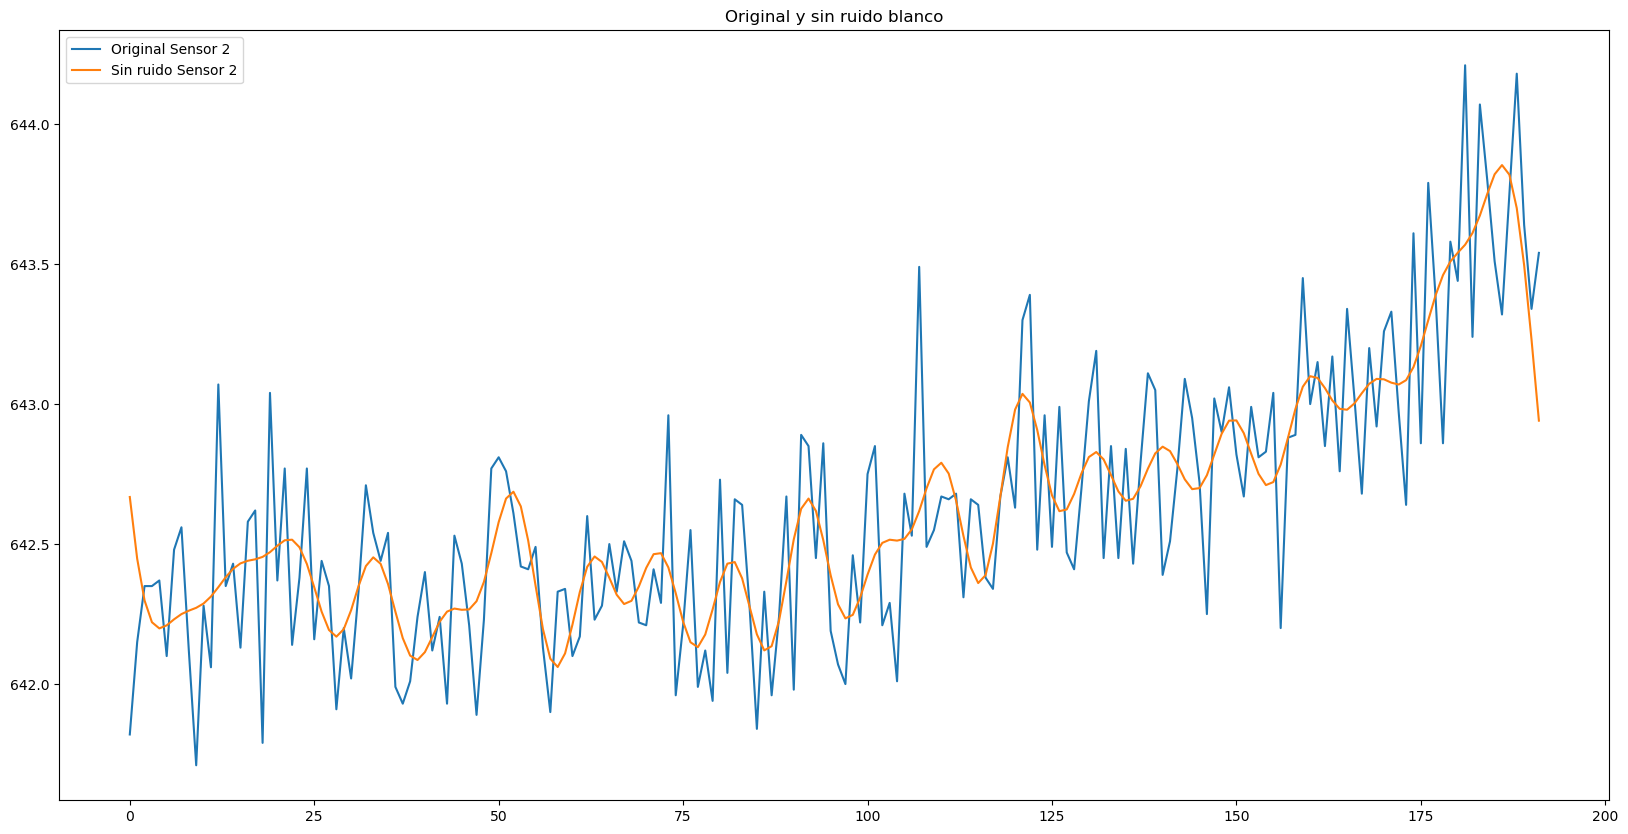

In [34]:
from scipy import fftpack
sample_freq = fftpack.fftfreq(s2_1_cycle.size, d=1)
sig_fft = fftpack.fft(s2_1_cycle)
pidxs = np.where(sample_freq > 0)
freqs = sample_freq[pidxs]
power = np.abs(sig_fft)[pidxs]

#Grafico de la frecuencia
plt.figure(1)
plt.plot(power)
print(power.size)

# filtrando el ruido y graficando
freq = freqs[power.argmax()]
sig_fft[np.abs(sample_freq) > freq*20] = 0
s2_1_cycle_smooth = fftpack.ifft(sig_fft)

plt.figure(figsize=(20,10))
line_1, = plt.plot(s2_1_cycle, label='line 1')
line_2, = plt.plot(s2_1_cycle_smooth, label='line 2')
plt.title('Original y sin ruido blanco')
plt.legend([line_1, line_2], ['Original Sensor 2', 'Sin ruido Sensor 2'])

In [30]:
def f(col):
    smooth_col = seasonal_decompose(col.values, freq=10).trend
    return smooth_col
transformed = train_data.drop(['cycle', 'setting1', 'setting2', 'setting3'], axis=1).groupby('id').transform(f)
transformed['id'] = train_data['id']

df_1 = train_data[['id', 'cycle', 'setting1', 'setting2', 'setting3']]
df_2 = transformed.groupby('id').ffill().bfill().drop('id', axis=1)
train = pd.concat([df_1, df_2], axis=1)

C:\Users\Porti\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
